# basic chatbot

https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup

In [41]:
from ibm_watsonx_ai import APIClient
from langchain_ibm import ChatWatsonx

project_id="2adbc31f-5dc4-4e42-b730-1e5e360727fd"
url="https://us-south.ml.cloud.ibm.com"
apikey="0cZb46prORvZpwwPng_oLDJOxt5SmJwRqzw0gAfZKJ5_"

parameters = {
    "frequency_penalty": 0,
    "max_tokens": 200,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

def create_chat_model(model_id):
    return ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)
model_id = "ibm/granite-3-8b-instruct"
chat_model = create_chat_model(model_id)
chat_model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 60, 'total_tokens': 70}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-c5bb1939dfdb0a7546154531a792368b', usage_metadata={'input_tokens': 60, 'output_tokens': 10, 'total_tokens': 70})

In [ ]:
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
import json

In [6]:
tavily_api_key = "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"
tavilySearchAPIWrapper = TavilySearchAPIWrapper(tavily_api_key=tavily_api_key)
search = TavilySearchResults(api_wrapper=tavilySearchAPIWrapper)
tool = TavilySearchResults(api_wrapper=tavilySearchAPIWrapper,  max_results=2) #increased number of results
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [11]:
tools = [tool]

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
llm_with_tools = chat_model.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [15]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

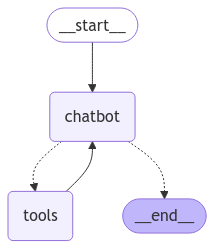

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [19]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: [{"url": "https://en.wikipedia.org/wiki/Kuchesfahan", "content": "Kuchesfahan or Kochesfahan is a city in, and the capital of, Kuchesfahan District of Rasht County, Gilan province, Iran. Kuchesfahan. \u0643\u0648\u0686\u0635\u0641\u0647\u0627\u0646. City."}, {"url": "https://en.wikipedia.org/wiki/Kuchesfahan_District", "content": "Kuchesfahan District (Persian: \u0628\u062e\u0634 \u06a9\u0648\u0686\u0635\u0641\u0647\u0627\u0646) is in Rasht County, Gilan province, Iran. Its capital is the city of Kuchesfahan."}]
Assistant: Kuchesfahan is a city located in Kuchesfahan District, Rasht County, Gilan province, Iran. It serves as the capital of Kuchesfahan District.
Assistant: 
Assistant: [{"url": "https://www.merriam-webster.com/dictionary/bye", "content": "The meaning of BYE is the position of a participant in a tournament who advances to the next round without playing. How to use bye in a"}, {"url": "https://www.vocabul

In [7]:
# simple hello

from langgraph.graph import Graph

In [2]:
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

In [ ]:


# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [7]:
app.invoke("Hello")

'Hello Hi there'

In [8]:

input = 'Hello'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hello Hi 

---

Output from node 'node_2':
---
Hello Hi there

---



In [9]:
# add llm

In [6]:
def function_1(input_1):
    response = chat_model.invoke(input_1)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)
chat_model
workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

NameError: name 'Graph' is not defined

In [12]:
app.invoke("Hey there")

'Agent Says: Hello! How can I assist you today?'

In [13]:
# City Temperature

In [14]:
def function_1(input_1):
    complete_query = "Your task is to provide city name based on the user query. \
         If the use enters the state, provide also the state. Return city and state in a comma separated format. \
        Following is the user query: " + input_1
    response = chat_model.invoke(complete_query)
    return response.content

    
def function_2(input_2):
    return "Agent Says: " + input_2

In [15]:
# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [16]:
app.invoke("What's the temperature in Charlotte")

'Agent Says: Charlotte, North Carolina'

In [43]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.document_loaders import WeatherDataLoader

apikey= 'c0a856e7b381cf41550a94999c5d972d'
weather = OpenWeatherMapAPIWrapper(openweathermap_api_key =apikey )
weather.run("greensboro")

'In greensboro, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 2.06 m/s, direction: 0°\nHumidity: 30%\nTemperature: \n  - Current: 11.74°C\n  - High: 12.88°C\n  - Low: 11.09°C\n  - Feels like: 9.75°C\nRain: {}\nHeat index: None\nCloud cover: 20%'

In [19]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = chat_model.invoke(complete_query)
    return response.content

def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

In [20]:
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('agent', 'tool')

workflow.set_entry_point("agent")
workflow.set_finish_point("tool")

app = workflow.compile()

app.invoke("What's the temperature in greensboro")


'In Greensboro, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 1.54 m/s, direction: 0°\nHumidity: 32%\nTemperature: \n  - Current: 10.96°C\n  - High: 12.17°C\n  - Low: 10.35°C\n  - Feels like: 8.95°C\nRain: {}\nHeat index: None\nCloud cover: 20%'

In [21]:
input = "What's the temperature in greensboro"
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Greensboro

---

Output from node 'tool':
---
In Greensboro, the current weather is as follows:
Detailed status: few clouds
Wind speed: 1.54 m/s, direction: 0°
Humidity: 32%
Temperature: 
  - Current: 10.96°C
  - High: 12.17°C
  - Low: 10.35°C
  - Feels like: 8.95°C
Rain: {}
Heat index: None
Cloud cover: 20%

---



In [23]:
# add filter

In [24]:
def function_3(input_3):
    complete_query = "Your task is to provide info concisely based on the user query. Following is the user query: " + "user input"
    response = chat_model.invoke(complete_query)
    return response.content

In [25]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []


AgentState

{'messages': []}

In [38]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide city name based on the user query. \
         If the use enters the state, provide also the state. Return city and state in a comma separated format. \
        Following is the user query: " + user_input
    response = chat_model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper(openweathermap_api_key =apikey )
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = "Your task is to provide info concisely based on the user query and the available information from the internet. \
                        Following is the user query: " + user_input + " Available information: " + available_info
    response = chat_model.invoke(agent2_query)
    return response.content

In [39]:
from langgraph.graph import Graph

workflow = Graph()


workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()

In [44]:
inputs = {"messages": ["what is the temperature in matthews "]}
app.invoke(inputs)

'The current temperature in Matthews, North Carolina is 13.39°C. The high for the day is expected to reach 14.34°C and the low will be 12.0°C. It feels like 11.57°C due to wind and humidity. The weather is currently clear with no rain and a wind speed of 1.34 m/s from the southwest.'

In [45]:
input = {"messages": ["what is the temperature in matthews"]}
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': ['what is the temperature in matthews', 'Matthews, North Carolina']}

---

Output from node 'tool':
---
{'messages': ['what is the temperature in matthews', 'Matthews, North Carolina', 'In Matthews, North Carolina, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 1.34 m/s, direction: 172°\nHumidity: 30%\nTemperature: \n  - Current: 13.39°C\n  - High: 14.34°C\n  - Low: 12.0°C\n  - Feels like: 11.57°C\nRain: {}\nHeat index: None\nCloud cover: 0%']}

---

Output from node 'responder':
---
The current temperature in Matthews, North Carolina is 13.39°C. The high for the day is expected to reach 14.34°C and the low will be 12.0°C. The weather is currently clear with a wind speed of 1.34 m/s from the southwest and humidity at 30%. It feels like 11.57°C due to the clear sky and light breeze. There is no rainfall and no heat index reported.

---



# better format

In [116]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun


In [122]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage
from IPython.display import Image, display


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [118]:
weather_apikey= 'c0a856e7b381cf41550a94999c5d972d'
tool = OpenWeatherMapQueryRun(api_wrapper = OpenWeatherMapAPIWrapper(openweathermap_api_key =weather_apikey ))

tools = [tool]
llm_with_tools = chat_model.bind_tools(tools)   #Bind tool-like objects to this chat model.

In [ ]:
def chatbot(state: State):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

#call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, #which tells the graph that whenever the chatbot node completes to check this function to see where to go next.
#returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.

graph_builder.add_conditional_edges(               
    "chatbot",
    tools_condition,  # route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [125]:
messages = "what is the temperature in charlotte"
u={"messages": [HumanMessage(content=messages)]}
graph.invoke(u)

{'messages': [HumanMessage(content='what is the temperature in charlotte', additional_kwargs={}, response_metadata={}, id='b4603ec0-64d1-44db-a6e7-ea62ce280bbc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-4294caebd32d4cf9bfc7e7a3d7c68145', 'type': 'function', 'function': {'name': 'open_weather_map', 'arguments': '{"location": "charlotte"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 249, 'total_tokens': 276}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-2b8397f0a79367a05073047d543363bb', tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'charlotte'}, 'id': 'chatcmpl-tool-4294caebd32d4cf9bfc7e7a3d7c68145', 'type': 'tool_call'}], usage_metadata={'input_tokens': 249, 'output_tokens': 27, 'total_tokens': 276}),
  ToolMessage(content='In charlotte, the current weather is as follows:\nDetailed status: scattered clouds\nWind speed: 0.45 m

In [126]:
for output in graph.stream(u):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'chatbot':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-b50e12f76a654664a219d70002e96434', 'type': 'function', 'function': {'name': 'open_weather_map', 'arguments': '{"location": "charlotte"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 249, 'total_tokens': 276}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-09c3ee781185f31b918cc6fa6828a1e3', tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'charlotte'}, 'id': 'chatcmpl-tool-b50e12f76a654664a219d70002e96434', 'type': 'tool_call'}], usage_metadata={'input_tokens': 249, 'output_tokens': 27, 'total_tokens': 276})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='In charlotte, the current weather is as follows:\nDetailed status: scattered clouds\nWind speed: 0.45 m/s, direction: 185°\nHumidity: 32%\nTemperature: \n  - Current: 13.07°

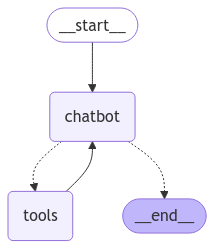

In [123]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [127]:
# addd memory